In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

C:\Users\patri\AppData\Local\Temp\ipykernel_5252\3470878462.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


Modified timestamps for file handwritingData_1727517549959.svc:
0      0
1    145
2    250
3    335
4    430
Name: timestamp, dtype: int32




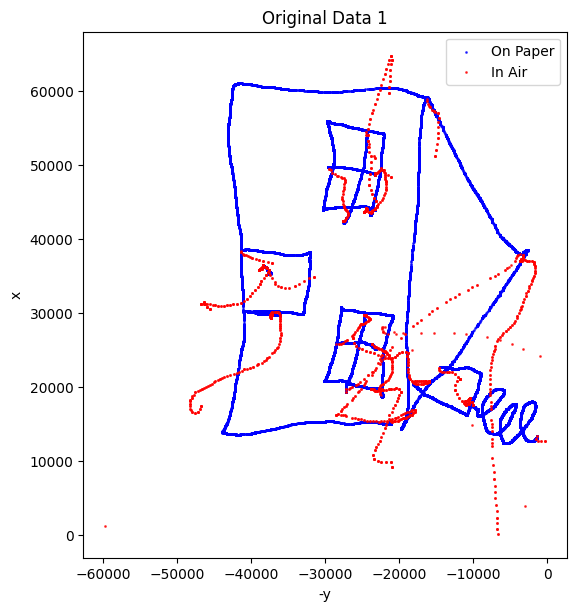

Number of processed files: 1
Average number of data points: 33643


In [2]:
# Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points

directory = '../uploads'  # Directory where the .svc files are stored
data_frames, processed_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

In [3]:
# Assume the first processed DataFrame is the one we want to read
df = data_frames[0]  # Using the first DataFrame from the list returned by `upload_and_process_files`

# Convert the 'timestamp' column to numeric for calculations (if not already done)
df['timestamp'] = pd.to_numeric(df['timestamp'])

# Sort the DataFrame by timestamp (should already be sorted in the function)
df.sort_values('timestamp', inplace=True)

# Calculate the differences between consecutive timestamps (optional for gap finding)
df['time_diff'] = df['timestamp'].diff()

# Identify the indices where the time difference is greater than 30,000 milliseconds
gap_indices = df.index[df['time_diff'] > 30000].tolist()

# Create an empty list to hold the new rows
new_rows = []

# Fill in the gaps with 70 milliseconds intervals
for idx in gap_indices:
    # Check if the next index is valid
    if idx + 1 < len(df):
        # Get the current and next timestamps
        current_timestamp = df.at[idx, 'timestamp']
        next_timestamp = df.at[idx + 1, 'timestamp']
        
        # Calculate how many entries we need to fill in
        num_fill_entries = (next_timestamp - current_timestamp) // 20000

        # Generate the timestamps to fill the gap
        for i in range(1, num_fill_entries + 1):
            new_timestamp = current_timestamp + i * 70
            
            # Create a new row to fill in with NaN for x and y
            new_row = {
                'x': np.nan,  # Set x to NaN
                'y': np.nan,  # Set y to NaN
                'timestamp': new_timestamp,
                'pen_status': 0,        # You can set this to your desired value
                'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                'pressure': df.at[idx, 'pressure']  # Use the current pressure value
            }
            
            # Append the new row to the list of new rows
            new_rows.append(new_row)

# Create a DataFrame from the new rows
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the original DataFrame with the new rows DataFrame
df = pd.concat([df, new_rows_df], ignore_index=True)

# Sort the DataFrame by timestamp to maintain order
df.sort_values('timestamp', inplace=True)

# Reset index after sorting
df.reset_index(drop=True, inplace=True)

# Interpolate NaN values in 'x' and 'y' columns based on nearest neighbors
# Check for NaN entries before interpolation
if df[['x', 'y']].isnull().any().any():
    df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

# Drop the 'time_diff' column as it's no longer needed
df.drop(columns=['time_diff'], inplace=True)

processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                    for df, scaler in zip(data_frames, scalers)]
avg_data_points = df.shape[0]

In [4]:
import os

# Define a valid directory path where you want to save the file
output_dir = './imputed/'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the full file path including the filename
output_path = os.path.join(output_dir, 'processed_data.svc')

# Save the DataFrame as a space-separated .svc file
df.to_csv(output_path, sep=' ', index=False, header=False)

print(f"File saved to: {output_path}")


File saved to: ./imputed/processed_data.svc


Modified timestamps for file processed_data.svc:
0        0
1      105
2      190
3      285
4    18635
Name: timestamp, dtype: int32




C:\Users\patri\AppData\Local\Temp\ipykernel_5252\657295717.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


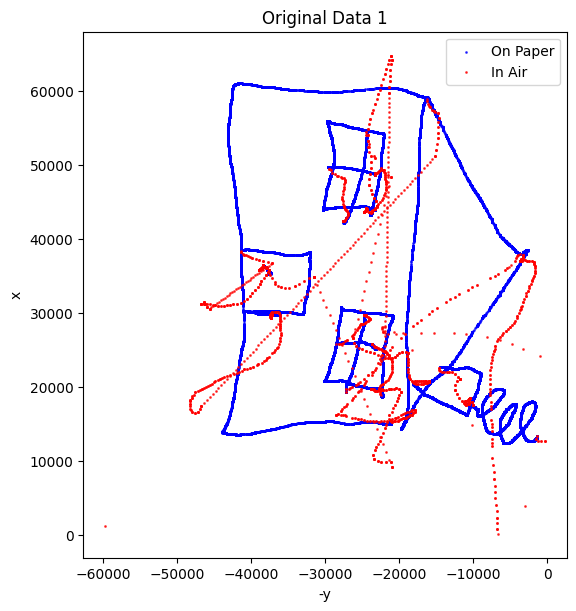

Number of processed files: 1
Average number of data points: 33853


In [5]:
# Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points

directory = './imputed'  # Directory where the .svc files are stored
data_frames, processed_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

In [6]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, **kwargs):  # Added **kwargs to handle extra arguments
        super(VAE, self).__init__(**kwargs)  # Pass kwargs to the parent class
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        # Handle any unexpected keys like 'trainable' by removing them
        config.pop('trainable', None)
        config.pop('dtype', None)  # Also remove 'dtype' if included
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        # Add the VAE-specific arguments
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 128
beta = 0.0001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
# Cell 4 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0), length_variability=0.05):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        # Select input data sequentially, cycling through if necessary
        selected_data = processed_data[i % num_input_files]
        
        # Determine the number of points for this augmented dataset
        num_points = int(avg_data_points * (1 + np.random.uniform(-length_variability, length_variability)))
        
        # Generate a random latent variability for this augmented dataset
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        # Encode and reparameterize
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        # Decode
        augmented_data = model.decode(z).numpy()
        
        # Adjust the number of points
        if num_points > augmented_data.shape[0]:
            # If we need more points, duplicate some randomly
            extra_indices = np.random.choice(augmented_data.shape[0], num_points - augmented_data.shape[0])
            augmented_data = np.vstack((augmented_data, augmented_data[extra_indices]))
        elif num_points < augmented_data.shape[0]:
            # If we need fewer points, randomly select a subset
            keep_indices = np.random.choice(augmented_data.shape[0], num_points, replace=False)
            augmented_data = augmented_data[keep_indices]

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/20: 100%|██████████| 67/67 [00:03<00:00, 20.18batch/s, Generator Loss=0.00199, Reconstruction Loss=0.00179, KL Loss=2]   


Epoch 1: Generator Loss = 0.003120, Reconstruction Loss = 0.002878, KL Divergence Loss = 2.416699
NRMSE = 0.236550


Epoch 2/20: 100%|██████████| 67/67 [00:00<00:00, 125.73batch/s, Generator Loss=0.00113, Reconstruction Loss=0.000969, KL Loss=1.63]


Epoch 2: Generator Loss = 0.002339, Reconstruction Loss = 0.002082, KL Divergence Loss = 2.564928
NRMSE = 0.238433


Epoch 3/20: 100%|██████████| 67/67 [00:00<00:00, 125.52batch/s, Generator Loss=0.000901, Reconstruction Loss=0.000705, KL Loss=1.96]


Epoch 3: Generator Loss = 0.001822, Reconstruction Loss = 0.001550, KL Divergence Loss = 2.721512
NRMSE = 0.239838


Epoch 4/20: 100%|██████████| 67/67 [00:00<00:00, 110.13batch/s, Generator Loss=0.00145, Reconstruction Loss=0.00127, KL Loss=1.84]  


Epoch 4: Generator Loss = 0.001446, Reconstruction Loss = 0.001163, KL Divergence Loss = 2.825013
NRMSE = 0.240892


Epoch 5/20: 100%|██████████| 67/67 [00:00<00:00, 126.15batch/s, Generator Loss=0.000799, Reconstruction Loss=0.000602, KL Loss=1.97]


Epoch 5: Generator Loss = 0.001135, Reconstruction Loss = 0.000843, KL Divergence Loss = 2.922029
NRMSE = 0.241747


Epoch 6/20: 100%|██████████| 67/67 [00:00<00:00, 103.48batch/s, Generator Loss=0.00127, Reconstruction Loss=0.00103, KL Loss=2.38]  


Epoch 6: Generator Loss = 0.000908, Reconstruction Loss = 0.000609, KL Divergence Loss = 2.994238
NRMSE = 0.242268


Epoch 7/20: 100%|██████████| 67/67 [00:00<00:00, 125.86batch/s, Generator Loss=0.000552, Reconstruction Loss=0.000348, KL Loss=2.05]


Epoch 7: Generator Loss = 0.000739, Reconstruction Loss = 0.000433, KL Divergence Loss = 3.054133
NRMSE = 0.241709


Epoch 8/20: 100%|██████████| 67/67 [00:00<00:00, 121.78batch/s, Generator Loss=0.000481, Reconstruction Loss=0.000238, KL Loss=2.43]


Epoch 8: Generator Loss = 0.000655, Reconstruction Loss = 0.000347, KL Divergence Loss = 3.080159
NRMSE = 0.241526


Epoch 9/20: 100%|██████████| 67/67 [00:00<00:00, 99.92batch/s, Generator Loss=0.000697, Reconstruction Loss=0.000467, KL Loss=2.29] 


Epoch 9: Generator Loss = 0.000600, Reconstruction Loss = 0.000294, KL Divergence Loss = 3.066363
NRMSE = 0.241690


Epoch 10/20: 100%|██████████| 67/67 [00:00<00:00, 125.28batch/s, Generator Loss=0.00048, Reconstruction Loss=0.000256, KL Loss=2.24] 


Epoch 10: Generator Loss = 0.000555, Reconstruction Loss = 0.000250, KL Divergence Loss = 3.049430
NRMSE = 0.241842


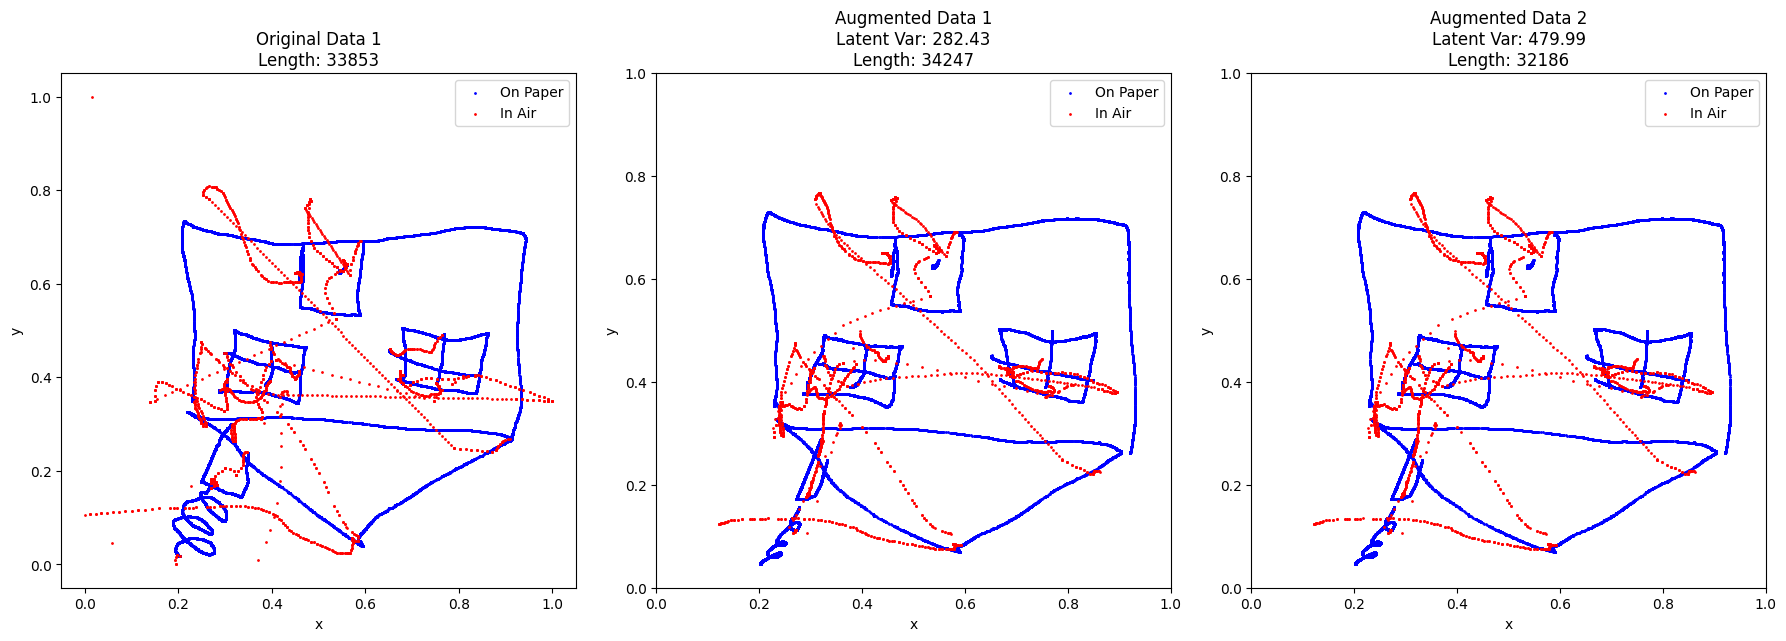

Epoch 11/20: 100%|██████████| 67/67 [00:00<00:00, 96.96batch/s, Generator Loss=0.000637, Reconstruction Loss=0.000413, KL Loss=2.25] 


Epoch 11: Generator Loss = 0.000530, Reconstruction Loss = 0.000227, KL Divergence Loss = 3.027039
NRMSE = 0.242069


Epoch 12/20: 100%|██████████| 67/67 [00:00<00:00, 92.88batch/s, Generator Loss=0.000448, Reconstruction Loss=0.000218, KL Loss=2.3]  


Epoch 12: Generator Loss = 0.000498, Reconstruction Loss = 0.000199, KL Divergence Loss = 2.994847
NRMSE = 0.242198


Epoch 13/20: 100%|██████████| 67/67 [00:00<00:00, 101.45batch/s, Generator Loss=0.000407, Reconstruction Loss=0.000185, KL Loss=2.22]


Epoch 13: Generator Loss = 0.000480, Reconstruction Loss = 0.000184, KL Divergence Loss = 2.966734
NRMSE = 0.241784


Epoch 14/20: 100%|██████████| 67/67 [00:00<00:00, 89.37batch/s, Generator Loss=0.000483, Reconstruction Loss=0.000252, KL Loss=2.31]


Epoch 14: Generator Loss = 0.000464, Reconstruction Loss = 0.000170, KL Divergence Loss = 2.937056
NRMSE = 0.242079


Epoch 15/20: 100%|██████████| 67/67 [00:00<00:00, 121.82batch/s, Generator Loss=0.00042, Reconstruction Loss=0.000189, KL Loss=2.32] 


Epoch 15: Generator Loss = 0.000450, Reconstruction Loss = 0.000160, KL Divergence Loss = 2.907195
NRMSE = 0.241887


Epoch 16/20: 100%|██████████| 67/67 [00:00<00:00, 120.41batch/s, Generator Loss=0.000341, Reconstruction Loss=0.000136, KL Loss=2.05]


Epoch 16: Generator Loss = 0.000437, Reconstruction Loss = 0.000150, KL Divergence Loss = 2.870952
NRMSE = 0.242171


Epoch 17/20: 100%|██████████| 67/67 [00:00<00:00, 110.03batch/s, Generator Loss=0.000374, Reconstruction Loss=0.000151, KL Loss=2.22]


Epoch 17: Generator Loss = 0.000427, Reconstruction Loss = 0.000143, KL Divergence Loss = 2.837871
NRMSE = 0.242291


Epoch 18/20: 100%|██████████| 67/67 [00:00<00:00, 98.52batch/s, Generator Loss=0.000369, Reconstruction Loss=0.000135, KL Loss=2.34] 


Epoch 18: Generator Loss = 0.000416, Reconstruction Loss = 0.000135, KL Divergence Loss = 2.806284
NRMSE = 0.242079


Epoch 19/20: 100%|██████████| 67/67 [00:00<00:00, 116.47batch/s, Generator Loss=0.000349, Reconstruction Loss=0.000136, KL Loss=2.13]


Epoch 19: Generator Loss = 0.000408, Reconstruction Loss = 0.000130, KL Divergence Loss = 2.775778
NRMSE = 0.241982


Epoch 20/20: 100%|██████████| 67/67 [00:00<00:00, 107.76batch/s, Generator Loss=0.00039, Reconstruction Loss=0.000172, KL Loss=2.18] 


Epoch 20: Generator Loss = 0.000401, Reconstruction Loss = 0.000126, KL Divergence Loss = 2.749218
NRMSE = 0.241831


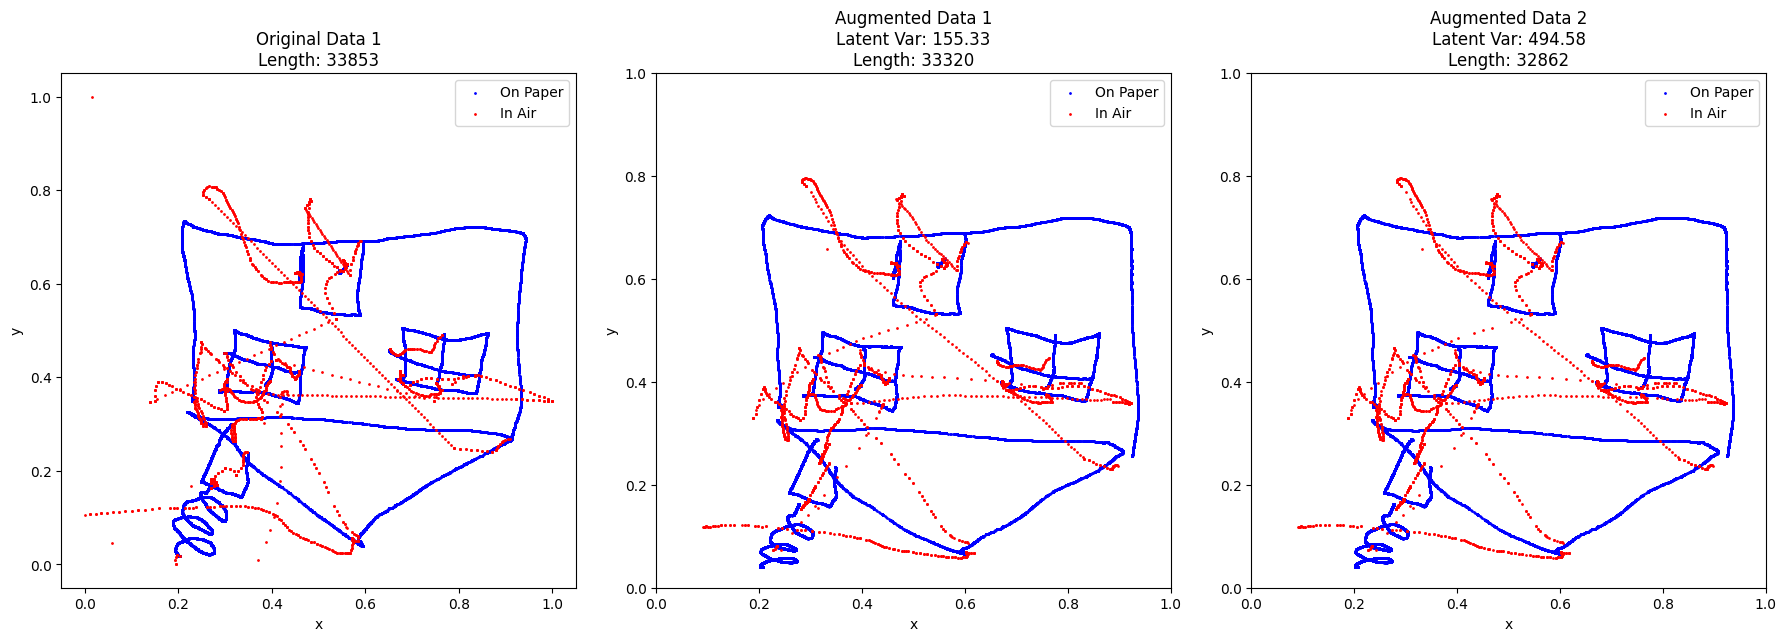

Final NRMSE: 0.241831
Training completed.
VAE model saved.


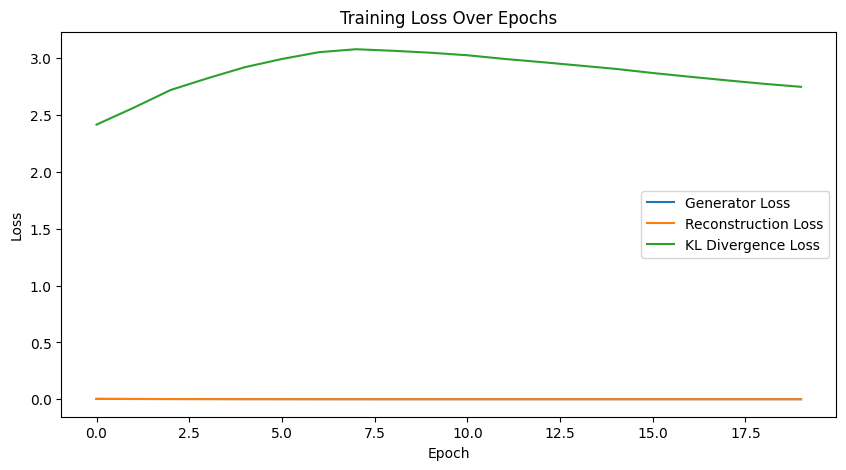

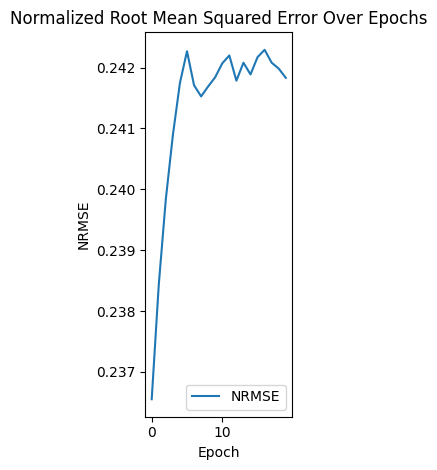

In [12]:
#Cell 5
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss - 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 99
lstm_interval = 1
epochs = 20
visual_per_num_epoch = 10
num_augmented_files = 2

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                # Use LSTM discriminator after vae_epochs and every lstm_interval
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)  # Reshape for LSTM input
            generated_data = tf.expand_dims(augmented_data, axis=0)

            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")

    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)
        length_variability = 0.05
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range, length_variability)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))
        
        for i, original_data in enumerate(processed_data):
            original_on_paper = original_data[original_data[:, 3] == 1]
            original_in_air = original_data[original_data[:, 3] == 0]
            axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}\nLength: {len(original_data)}')
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('y')
            axs[i].set_aspect('equal')
            axs[i].legend()

        # Set consistent axis limits for square aspect ratio
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}\nLatent Var: {latent_var:.2f}\nLength: {length}')
            axs[i+len(processed_data)].set_xlabel('x')
            axs[i+len(processed_data)].set_ylabel('y')
            axs[i+len(processed_data)].set_aspect('equal')
            axs[i+len(processed_data)].set_xlim(x_min, x_max)
            axs[i+len(processed_data)].set_ylim(y_min, y_max)
            axs[i+len(processed_data)].legend()

        plt.tight_layout()
        plt.show()

# Final output of metrics
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

vae.save('saved_vae_model.h5')
print("VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pretrained VAE model loaded.


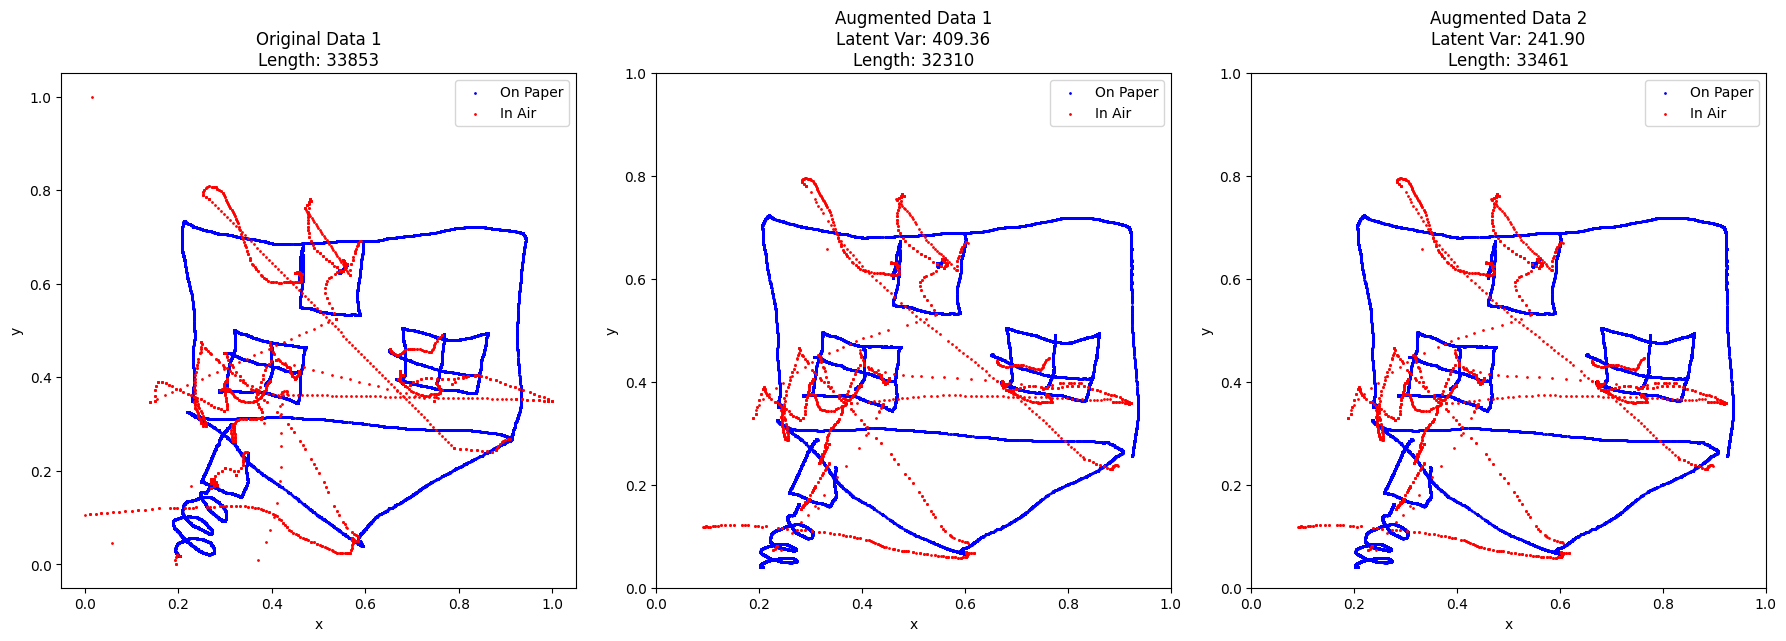

In [13]:
# Cell 6
# Load the pretrained VAE model
with custom_object_scope({'VAE': VAE}):
    vae_pretrained = load_model('saved_vae_model.h5')
print("Pretrained VAE model loaded.")
base_latent_variability = 100.0
latent_variability_range = (0.1, 5.0)
length_variability = 0.05
num_augmented_files = 2
# Generate augmented data using the pretrained model
augmented_datasets = generate_augmented_data(vae_pretrained, num_augmented_files, avg_data_points, processed_data, 
                                             base_latent_variability, latent_variability_range, length_variability)




# Calculate actual latent variabilities and lengths used
latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
augmented_lengths = [len(data) for data in augmented_datasets]

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))

for i, original_data in enumerate(processed_data):
    original_on_paper = original_data[original_data[:, 3] == 1]
    original_in_air = original_data[original_data[:, 3] == 0]
    axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i].set_title(f'Original Data {i+1}\nLength: {len(original_data)}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_aspect('equal')
    axs[i].legend()

# Set consistent axis limits for square aspect ratio
x_min = min(data[:, 0].min() for data in processed_data)
x_max = max(data[:, 0].max() for data in processed_data)
y_min = min(data[:, 1].min() for data in processed_data)
y_max = max(data[:, 1].max() for data in processed_data)

for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
    augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
    axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}\nLatent Var: {latent_var:.2f}\nLength: {length}')
    axs[i+len(processed_data)].set_xlabel('x')
    axs[i+len(processed_data)].set_ylabel('y')
    axs[i+len(processed_data)].set_aspect('equal')
    axs[i+len(processed_data)].set_xlim(x_min, x_max)
    axs[i+len(processed_data)].set_ylim(y_min, y_max)
    axs[i+len(processed_data)].legend()

plt.tight_layout()
plt.show()

In [10]:
# Cell 7
def download_augmented_data(augmented_datasets, scaler, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, augmented_data in enumerate(augmented_datasets):
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :3]),  # Inverse scale x, y, timestamp
            augmented_data[:, 3]  # Keep pen_status unchanged
        ))

        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with the same scaler for all augmented datasets
download_augmented_data(augmented_datasets, scalers[0])


Saved augmented_data\augmented_data_1.csv
Saved augmented_data\augmented_data_2.csv


In [11]:
#Cell 8 Function to visualize the latent space with a color gradient
def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])

NameError: name 'TSNE' is not defined